In [1]:
# In this script we want to determine the contribution of each pathway on stacked trimer assembly
# Name: Leo Lagunes and Paige M.
# Date: 10/17/22 

# Last update: 10/17/22 

# IMPORTANT NOTE: The equations were written and developed by Drs. Eric Deeds and Koan Briggs, this code was developed by LL 

# Running in python 


In [2]:
# ---------------------------------------------------
# --- packages to use ---
# ---------------------------------------------------

# First we need to import all of the packages we will be using!",
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
import seaborn as sns # for the heatmaps
from datetime import date # to print date
from datetime import datetime
from matplotlib.ticker import LogLocator
import matplotlib

print('All packages loaded!')

All packages loaded!


In [2]:
# ---------------------------------------------------
# --- BINARY Trees ---
# --------------------------------------------------- 

# Example in python 

class BinaryTreeNode:
  def __init__(self, data):
    self.data = data
    self.leftChild = None
    self.rightChild=None
    
# -------------------------------
# --- Define a tree ---
# -------------------------------
# Defining nodes
node1 = BinaryTreeNode(50)
node2 = BinaryTreeNode(20)
node3 = BinaryTreeNode(45)
node4 = BinaryTreeNode(11)
node5 = BinaryTreeNode(15)
node6 = BinaryTreeNode(30)
node7 = BinaryTreeNode(78)

# defining children in the tree
node1.leftChild = node2
node1.rightChild = node3
node2.leftChild = node4
node2.rightChild = node5
node3.leftChild = node6
node3.rightChild = node7

# printing useful information about the tree
print("Root Node is:")
print(node1.data)

Root Node is:
50


In [ ]:
# ---------------------------------------------------
# --- BINARY Trees for pathways ---
# --------------------------------------------------- 

# I need to define a tree for every pathway in the stacked trimer assembly 
# there are 46 pathways possible when forming the stacked trimer.




In [ ]:
# From Koan's code


# def SpeciesToIndex(S, Species):
#     return int(np.where(np.array(Species.values())==S)[0])
def SpeciesToIndex(S, Species = False):
    SpeciesIndex = {y:i for (i, (x,y)) in enumerate(Species.items())}
    return SpeciesIndex[S]

# def SpeciesToInt(S):
#     return int(S[::2],2)
def SpeciesToName(S, Species):
    return Species.values()[S]

class Probabilities(object):
    def __init__(self, Data, Concentrations=False):
        self.Data = Data
        self.ProteinsInSpecies = [sum(x == "1" for x in Data.Species.values()[i]) for i in range(Data.SpeciesCount)]
        self._GenReactionsByProduct()
        self.UpdateNorms(Concentrations)

    def LookupReaction(self, Product, R1 = -1, R2 = -1):
        Out = deque()
        for R in self.Data.Reactions:
            if R[3] == Product:
                Out.append(R)
        if R1 == -1 and R2 == -1:
            return Out
        R1 = int(R1)
        R2 = int(R2)
        for R in Out:
            if R[0] == R1 and R[1] == R2:
                return R
            if R[1] == R1 and R[0] == R2:
                return R
        return False

    def _GenReactionsByProduct(self):
        ReactionsByProduct = OrderedDict()
        for Species in self.Data.SpeciesConvert.values():
            for R in self.LookupReaction(Species):
                try:
                    ReactionsByProduct[Species].append(R)
                except:
                    ReactionsByProduct[Species] = list()
                    ReactionsByProduct[Species].append(R)
        self.ReactionsByProduct = ReactionsByProduct

    def UpdateNorms(self, Concentrations = False): 
        # Generate the normalization factors (Return list in the same order as the Data.Species list)
        if hasattr(Concentrations, '__iter__'):
            NormsBySpecies = np.zeros(len(Concentrations))
        else:
            Concentrations = np.ones(self.Data.SpeciesCount)
            NormsBySpecies = np.zeros(self.Data.SpeciesCount)

        for i, Rs in self.ReactionsByProduct.items():
            #print "{} : {}".format(i,Rs)
            for R in Rs:
                # R[2]: Forward
                # R[0]: Reactant 1
                # R[1]: Reactant 2
                # R[3]: Product
                NormsBySpecies[i] += R[2]*Concentrations[R[0]]*Concentrations[R[1]]
                #print "{} : {}".format(R, NormsBySpecies[i])
        self.Concentrations = Concentrations 
        self.NormsBySpecies = NormsBySpecies

    def UpdateConcentrations(self, Fraction, Concentration): 
        #RealConc = np.zeros_like(Fraction)
        RealConc = Fraction*Concentration/self.ProteinsInSpecies
        self.UpdateNorms(RealConc)

    def ReactionFlux(self, Product, R1, R2):
        Forward = self.LookupReaction(Product, R1, R2)
        if hasattr(Forward, '__iter__'):
            Forward = Forward[2]
        else:
            print "Reaction for P: {} R1: {} R2: {} Not Found!!!!".format(Product, R1, R2)
        if self.Concentrations[R1]*self.Concentrations[R2] != 0.0:
            return Forward*self.Concentrations[R1]*self.Concentrations[R2]/(self.NormsBySpecies[Product])
        return 0.0

    def NodeFlux(self, Graph, Node = "Root"):
        if Node == "Root":
            Node = self.Data.Species.values()[-1] # Root Node Name
        Product = nx.get_node_attributes(Graph,"Product")[Node]
        R1 = nx.get_node_attributes(Graph,"Reactant1")[Node]
        R2 = nx.get_node_attributes(Graph,"Reactant2")[Node]
        return self.ReactionFlux(Product,R1,R2)

    def PathIndependentFlux(self, Graph, Probability = True):
        Product = nx.get_node_attributes(Graph,"Product").values()
        R1 = nx.get_node_attributes(Graph,"Reactant1").values()
        R2 = nx.get_node_attributes(Graph,"Reactant2").values()
        Flux = 1.0
        for i in range(len(Product)):
            Flux *= self.ReactionFlux(Product[i],R1[i],R2[i])
        if not Probability:
            # Remove normalization from last step
            Flux *= self.NormsBySpecies[-1]
        return Flux

    def GetChildren(self, Graph, Node):
        return Graph.successors(Node)


In [2]:
# ---------------------------------------------------
# --- LIST OF FUNCTIONS ---
# ---------------------------------------------------

# All functions necessary are in this cell

# ---------------------------------------------------    
# --- Keff function ---
# ---------------------------------------------------
def keff(i,j):
    # calculate the k_effective value given the i,j indices and the kd's (binding affinities)
    ℯ = math.e
    #kd1 = kds[0]; kd2 = kds[1]
    keff= kOn*(kd1**i)*(kd2**j)*ℯ**(-(i+j-1)*9/0.6)
    
    return keff

# ---------------------------------------------------
# --- EJD Eqns for stacked trimer ---   
# ---------------------------------------------------
def stackedTrimer(states, t):
    #x0Val = paramvaluesList[0] # initial condition for x1 
    x = states
    # list of ode's
    dx_0 = - 2*kOn*0.5*x[0]*x[0] + 1*keff(1,0)*x[1] - 2*kOn*0.5*x[0]*x[0] + 1*keff(1,0)*x[1] - 1*kOn*0.5*x[0]*x[0] + 1*keff(0,1)*x[2] - 1*kOn*0.5*x[0]*x[0] + 1*keff(0,1)*x[2] - 1*kOn*1*x[0]*x[1] + 3*keff(2,0)*x[3] - 1*kOn*1*x[0]*x[1] + 1*keff(0,1)*x[4] - 1*kOn*1*x[0]*x[1] + 1*keff(0,1)*x[5] - 2*kOn*1*x[0]*x[2] + 1*keff(1,0)*x[5] - 2*kOn*1*x[0]*x[2] + 1*keff(1,0)*x[4] - 3*kOn*1*x[0]*x[3] + 1*keff(0,1)*x[6] - 1*kOn*1*x[0]*x[4] + 1*keff(2,0)*x[6] - 1*kOn*1*x[0]*x[4] + 2*keff(1,0)*x[7] - 1*kOn*1*x[0]*x[4] + 2*keff(1,1)*x[8] - 1*kOn*1*x[0]*x[5] + 1*keff(2,0)*x[6] - 1*kOn*1*x[0]*x[5] + 2*keff(1,1)*x[8] - 1*kOn*1*x[0]*x[5] + 2*keff(1,0)*x[9] - 2*kOn*1*x[0]*x[6] + 2*keff(1,1)*x[10] - 2*kOn*1*x[0]*x[7] + 1*keff(2,1)*x[10] - 2*kOn*1*x[0]*x[8] + 1*keff(2,0)*x[10] - 2*kOn*1*x[0]*x[9] + 1*keff(2,1)*x[10] - 1*kOn*1*x[0]*x[10] + 6*keff(2,1)*x[11] + Q - δ*x[0] 
    dx_1 = + 2*kOn*0.5*x[0]*x[0] - 1*keff(1,0)*x[1] - 1*kOn*1*x[0]*x[1] + 3*keff(2,0)*x[3] - 1*kOn*1*x[0]*x[1] + 1*keff(0,1)*x[4] - 1*kOn*1*x[0]*x[1] + 1*keff(0,1)*x[5] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,2)*x[8] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,2)*x[8] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,1)*x[9] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,1)*x[9] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,1)*x[7] - 1*kOn*0.5*x[1]*x[1] + 1*keff(0,1)*x[7] - 2*kOn*1*x[1]*x[2] + 1*keff(2,0)*x[6] - 3*kOn*1*x[1]*x[3] + 1*keff(0,2)*x[10] - 1*kOn*1*x[1]*x[4] + 1*keff(2,1)*x[10] - 1*kOn*1*x[1]*x[5] + 1*keff(2,1)*x[10] - 1*kOn*1*x[1]*x[6] + 6*keff(2,2)*x[11]  -  δ*x[1]
    dx_2 = + 1*kOn*0.5*x[0]*x[0] - 1*keff(0,1)*x[2] - 2*kOn*1*x[0]*x[2] + 1*keff(1,0)*x[5] - 2*kOn*1*x[0]*x[2] + 1*keff(1,0)*x[4] - 2*kOn*1*x[1]*x[2] + 1*keff(2,0)*x[6] - 4*kOn*0.5*x[2]*x[2] + 1*keff(2,0)*x[8] - 4*kOn*0.5*x[2]*x[2] + 1*keff(2,0)*x[8] - 2*kOn*1*x[2]*x[4] + 1*keff(3,0)*x[10] - 2*kOn*1*x[2]*x[5] + 1*keff(3,0)*x[10] - 2*kOn*1*x[2]*x[8] + 3*keff(4,0)*x[11]  - δ*x[2]
    dx_3 = + 1*kOn*1*x[0]*x[1] - 3*keff(2,0)*x[3] - 3*kOn*1*x[0]*x[3] + 1*keff(0,1)*x[6] - 3*kOn*1*x[1]*x[3] + 1*keff(0,2)*x[10] - 3*kOn*0.5*x[3]*x[3] + 1*keff(0,3)*x[11] - 3*kOn*0.5*x[3]*x[3] + 1*keff(0,3)*x[11]  - δ*x[3]
    dx_4 = + 1*kOn*1*x[0]*x[1] - 1*keff(0,1)*x[4] + 2*kOn*1*x[0]*x[2] - 1*keff(1,0)*x[4] - 1*kOn*1*x[0]*x[4] + 1*keff(2,0)*x[6] - 1*kOn*1*x[0]*x[4] + 2*keff(1,0)*x[7] - 1*kOn*1*x[0]*x[4] + 2*keff(1,1)*x[8] - 1*kOn*1*x[1]*x[4] + 1*keff(2,1)*x[10] - 2*kOn*1*x[2]*x[4] + 1*keff(3,0)*x[10] - 1*kOn*0.5*x[4]*x[4] + 3*keff(4,1)*x[11] - 1*kOn*0.5*x[4]*x[4] + 3*keff(4,1)*x[11]  - δ*x[4]
    dx_5 = + 1*kOn*1*x[0]*x[1] - 1*keff(0,1)*x[5] + 2*kOn*1*x[0]*x[2] - 1*keff(1,0)*x[5] - 1*kOn*1*x[0]*x[5] + 1*keff(2,0)*x[6] - 1*kOn*1*x[0]*x[5] + 2*keff(1,1)*x[8] - 1*kOn*1*x[0]*x[5] + 2*keff(1,0)*x[9] - 1*kOn*1*x[1]*x[5] + 1*keff(2,1)*x[10] - 2*kOn*1*x[2]*x[5] + 1*keff(3,0)*x[10] - 1*kOn*0.5*x[5]*x[5] + 3*keff(4,1)*x[11] - 1*kOn*0.5*x[5]*x[5] + 3*keff(4,1)*x[11]  - δ*x[5]
    dx_6 = + 3*kOn*1*x[0]*x[3] - 1*keff(0,1)*x[6] + 1*kOn*1*x[0]*x[4] - 1*keff(2,0)*x[6] + 1*kOn*1*x[0]*x[5] - 1*keff(2,0)*x[6] - 2*kOn*1*x[0]*x[6] + 2*keff(1,1)*x[10] + 2*kOn*1*x[1]*x[2] - 1*keff(2,0)*x[6] - 1*kOn*1*x[1]*x[6] + 6*keff(2,2)*x[11]  - δ*x[6]
    dx_7 = + 1*kOn*1*x[0]*x[4] - 2*keff(1,0)*x[7] - 2*kOn*1*x[0]*x[7] + 1*keff(2,1)*x[10] + 1*kOn*0.5*x[1]*x[1] - 1*keff(0,1)*x[7]  - δ*x[7]
    dx_8 = + 1*kOn*1*x[0]*x[4] - 2*keff(1,1)*x[8] + 1*kOn*1*x[0]*x[5] - 2*keff(1,1)*x[8] - 2*kOn*1*x[0]*x[8] + 1*keff(2,0)*x[10] + 1*kOn*0.5*x[1]*x[1] - 1*keff(0,2)*x[8] + 4*kOn*0.5*x[2]*x[2] - 1*keff(2,0)*x[8] - 2*kOn*1*x[2]*x[8] + 3*keff(4,0)*x[11]  - δ*x[8]
    dx_9 = + 1*kOn*1*x[0]*x[5] - 2*keff(1,0)*x[9] - 2*kOn*1*x[0]*x[9] + 1*keff(2,1)*x[10] + 1*kOn*0.5*x[1]*x[1] - 1*keff(0,1)*x[9]  - δ*x[9]
    dx_10 = + 2*kOn*1*x[0]*x[6] - 2*keff(1,1)*x[10] + 2*kOn*1*x[0]*x[7] - 1*keff(2,1)*x[10] + 2*kOn*1*x[0]*x[8] - 1*keff(2,0)*x[10] + 2*kOn*1*x[0]*x[9] - 1*keff(2,1)*x[10] - 1*kOn*1*x[0]*x[10] + 6*keff(2,1)*x[11] + 3*kOn*1*x[1]*x[3] - 1*keff(0,2)*x[10] + 1*kOn*1*x[1]*x[4] - 1*keff(2,1)*x[10] + 1*kOn*1*x[1]*x[5] - 1*keff(2,1)*x[10] + 2*kOn*1*x[2]*x[4] - 1*keff(3,0)*x[10] + 2*kOn*1*x[2]*x[5] - 1*keff(3,0)*x[10]  - δ*x[10]
    dx_11 = + 1*kOn*1*x[0]*x[10] - 6*keff(2,1)*x[11] + 1*kOn*1*x[1]*x[6] - 6*keff(2,2)*x[11] + 2*kOn*1*x[2]*x[8] - 3*keff(4,0)*x[11] + 3*kOn*0.5*x[3]*x[3] - 1*keff(0,3)*x[11] + 1*kOn*0.5*x[4]*x[4] - 3*keff(4,1)*x[11] + 1*kOn*0.5*x[5]*x[5] - 3*keff(4,1)*x[11]  - δ*x[11]
   
    states_prime = [dx_0, dx_1,dx_2,dx_3,dx_4, dx_5, dx_6,dx_7,dx_8,dx_9,dx_10,dx_11]
    
    return states_prime 

# ---------------------------------------------------
# --- Assembly Yield --- 
# ---------------------------------------------------
def calcAY24hrs(IC_1,XnTimePtsVec):
    # this function calculates the assembly yield for a time course of one species
    n=6; Xn = XnTimePtsVec;
    # --- calculate XT --- 
    # define XT as the IC of monomers (predefined)
    XT = IC_1; # print(XT)
    # --- calculate Yn ---
    Yn = n*Xn/XT;
    
    return Yn

# ---------------------------------------------------
# --- Assembly Yield vs IC --- 
# ---------------------------------------------------

def calcAYvsIC(minDeg_IC, maxDeg_IC, nICpts):
    # this function calculates the AY for varying values of IC
    mags = np.linspace(minDeg_IC, maxDeg_IC,nICpts)
    allICs = 10**mags
    # initialize lists to stor
    AY_list = []
    # loop to solve AY for each IC 
    for icVal in allICs:
        # for each IC calc the sols and AY 
        IC_1=icVal
        states_0 = [IC_1,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]
        # Now, integrate the ODEs and put the results in \"solution\"
        solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12) 
        # If the concentration is high, need different tols!
        if icVal > 10**-5:
            solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-9, atol = 1e-9)      
        else:
            solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12)            
        if kd1 == 10**-8:
            solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12) 
        
        tVec = t; xStkTrm_tps_1 = solution_1[:,-1]
        # calculate AY
        Yn_1 = calcAY24hrs(IC_1,xStkTrm_tps_1)
        # store the last AY value - since tc stops at 24hrs that's the AY at 24hrs
        AY_valStr = Yn_1[-1];
        AY_list.append(AY_valStr)
        
    return allICs, AY_list

# -----------------------------------------------------
# --- Assembly Yield with synthesis and degradation --- 
# -----------------------------------------------------
def calcAY_tc_synthDeg(tVec,solution_mat):
    nTpts = len(tVec)
    # vectors for each species (concentration at time t vector)
    x1 = solution_mat[:,0];x2 = solution_mat[:,1];x3 = solution_mat[:,2]
    x4 = solution_mat[:,3];x5 = solution_mat[:,4];x6 = solution_mat[:,5]
    x7 = solution_mat[:,6];x8 = solution_mat[:,7];x9 = solution_mat[:,8]
    x10 = solution_mat[:,9];x11 = solution_mat[:,10];x12 = solution_mat[:,11]

    # --- calculate Xn --- 
    # we only want AY for stacked trimer x11/x12
    Xn = x12
    # --- calculate XT and AY at each time point--- 
    XT = np.zeros(nTpts); Yn = np.zeros(nTpts);
    for timeT in range(0,nTpts):
        # for each time point calculate XT
        xt_val_i = 1*x1[timeT]+3*x2[timeT]+2*x3[timeT]+3*x4[timeT]+ 4*x5[timeT]+3*x6[timeT]+4*x7[timeT]+2*x8[timeT]+3*x9[timeT]+ 4*x10[timeT]+5*x11[timeT]+6*x12[timeT]
        XT[timeT]=xt_val_i;
        # --- calculate Yn --- 
        Yn_val = 6*Xn[timeT]/xt_val_i
        Yn[timeT] = Yn_val
    #print('XT: ', XT)
    # calc the AY at the 24hr mark - since solution_mat is calculated at 24hr mark, just send separetely the AY
    # AY24hrs = Yn[-1]
    
    XT = Q/δ; n=6; Xn = x12
    Yn = n*Xn/XT;
    
    return Yn


# --------------------------------------------------------------
# --- Assembly Yield with synthesis and degradation at 24hrs --- 
# --------------------------------------------------------------
def calcAY_synthDeg2hrs(tVec,solution_mat):
    nTpts = len(tVec)
    # vectors for each species (concentration at time t vector)
    x1 = solution_mat[:,0];x2 = solution_mat[:,1];x3 = solution_mat[:,2]
    x4 = solution_mat[:,3];x5 = solution_mat[:,4];x6 = solution_mat[:,5]
    x7 = solution_mat[:,6];x8 = solution_mat[:,7];x9 = solution_mat[:,8]
    x10 = solution_mat[:,9];x11 = solution_mat[:,10];x12 = solution_mat[:,11]

    # --- calculate Xn --- 
    # we only want AY for stacked trimer x11/x12
    #timeT = nTpts-1 # index of final point
    Xn = x12[-1]
    # --- calculate XT and AY at last time point (this is the 24hr mark) --- 
    xt_val_i = 1*x1[-1]+3*x2[-1]+2*x3[-1]+3*x4[-1]+ 4*x5[-1]+3*x6[-1]+4*x7[-1]+2*x8[-1]+3*x9[-1]+ 4*x10[-1]+5*x11[-1]+6*x12[-1]
    #print("XT: ", xt_val_i)
    # --- calculate Yn --- 
    Yn_val = 6*Xn/xt_val_i
    #print("YT: ", Yn_val)
    Yn24hrs = Yn_val
    
    return Yn24hrs

# ---------------------------------------------------
# --- Assembly Yield vs IC with synth/deg --- 
# ---------------------------------------------------
def calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC,nICpts):
    global Q
    # --- make vector of all IC's to loop through ---
    mags = np.linspace(minDeg_IC, maxDeg_IC,nICpts)
    allICs = 10**mags
    # --- initialize vector of AY values to return --- 
    AY_vals = np.zeros(nICpts); #print(AY_vals)
    # --- loop through all ICs and calc AY ---
    for icInd in range(0,nICpts):
        IC_1 = allICs[icInd]; #print("IC val i: ",IC_1)
        Q = IC_1*δ; # print("Q val i: ", Q) # redine Q for changing IC's
        # solve the ode's for this set of parameters
        states_0 = [IC_1,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]
        if IC_1 > 10**-5:
            solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-9, atol = 1e-9)      
        else:
            solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12)            
        if kd1 == 10**-8:
            solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12) 
        # may need another case for the gray lines !!!!
        #solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12)
        tVec=t;
        # --- calculate the AY at 24hrs --- 
        Yn_1 = calcAY_synthDeg2hrs(tVec,solution_1); #print("YN_i= ", Yn_1)
        # store this value 
        AY_vals[icInd]=Yn_1;
        
    return allICs, AY_vals

# ---------------------------------------------------
# --- Heatmap number formatting --- 
# ---------------------------------------------------
def precision_round(number, digits=3):
    power = "{:e}".format(number).split('e')[1]
    return round(number, -(int(power) - digits))

# ---------------------------------------------------
# --- Assembly Yield time course matrix --- 
# ---------------------------------------------------
def assemblyYield_tc_mainCurves(IC_1,allKdPairs,tPts):
    # This function returns a matrix of the time course for assembly yield of the main colored curves
    global kd1,kd2
    # --- variable initializations --- 
    states_0 = [IC_1,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]; tEnd = 6 # 24hrs
    t = 10**np.linspace(-3,tEnd,tPts) 
    nPairs = len(allKdPairs); allAYtc = np.zeros((nPairs,tPts))
    # loop through each pair of Kd1, kd2 combinations
    for kdI in range(0,nPairs): # for each IC 
        kdS = allKdPairs[kdI]; kd1 = kdS[0]; kd2 = kdS[1];
        # Now, integrate the ODEs and put the results in \"solution\"
        states_0 = [IC_1,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]
        solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-10, atol = 1e-10)
        tVec = t; xStkTrm_tps_1 = solution_1[:,-1]        
        # calculate AY
        Yn_1 = calcAY24hrs(IC_1,xStkTrm_tps_1)
        # store AY time course
        allAYtc[kdI,:]=Yn_1
    
    return allAYtc

def assemblyYield_tc_grayCurves(nRuns,minKdDeg,maxKdDeg,tPts,IC_1):
    # This function returns a matrix of all the gray lines for assembly yield
    global kd1,kd2
    # --- variable initializations ---
    allKd1 = 10**np.linspace(minKdDeg,maxKdDeg,nRuns); allKd2 = 10**np.linspace(minKdDeg,maxKdDeg,nRuns)
    tEnd = 6 # 24hrs
    t = 10**np.linspace(-3,tEnd,tPts) 
    allAYtcGray = np.zeros((nRuns,tPts))
    # --- loop through all cases --- 
    for runN in range(0,nRuns): # for each IC 
        if runN%100 == 0:
            print('Run: ', runN)
        kd1 = allKd1[runN]; kd2 = allKd1[runN];
        # Now, integrate the ODEs and put the results in \"solution\"
        states_0 = [IC_1,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]
        solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12)
        # change tols for some of the tc's
        if runN == 65:
            solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-9, atol = 1e-9)
        tVec = t; xStkTrm_tps_1 = solution_1[:,-1]        
        # calculate AY
        Yn_1 = calcAY24hrs(IC_1,xStkTrm_tps_1)
        # store AY time course
        allAYtcGray[runN,:]=Yn_1
        
    return allAYtcGray, tVec

# --- Today --- 
now = datetime.now(); dt_string = now.strftime("%m/%d/%Y %H:%M:%S")
today_pre = date.today()
today = today_pre.strftime("%m_%d_%y")
print("Functions ready...", dt_string)


Functions ready... 07/13/2022 11:34:29


Run:  0


/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Plot saved!


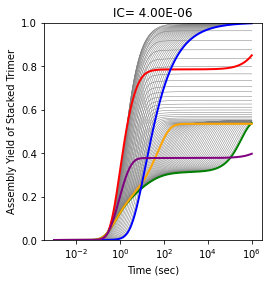

In [30]:
# ---------------------------------------------------
# --- Assembly Yield time courses no synth/deg ---
# ---------------------------------------------------
print("Working on all AY tc WITH NO synth/deg...")
# --- PARAMETERS ---
# List of fixed parameters
kOn = 10**6
δ = 0 # degradation rate parameter
Q = 0 # synthesis rate parameter

# List of parameters that will be explored 
IC_1 = 4*10**-6;tPts = 20000; 
# lists of kd1 and kd2 
allKdPairs =[[10**-3, 10**-12], [10**-12, 10**-12], [10**-8, 10**-8], [10**-3, 10**-3], [10**-12, 10**-3]]

# --- colored curves --- 
allAYtc = assemblyYield_tc_mainCurves(IC_1,allKdPairs,tPts)

# --- gray lines ----
nRuns = 100
minKdDeg = -3; maxKdDeg = -12
allAYtcGray_tot=assemblyYield_tc_grayCurves(nRuns,minKdDeg,maxKdDeg,tPts,IC_1)
allAYtcGray=allAYtcGray_tot[0]; tVec = allAYtcGray_tot[1]

# --- PLOT all curves --- 
fig = plt.figure()
ax = fig.add_subplot(111)
for runN in range(0,nRuns):
    plt.semilogx(tVec,allAYtcGray[runN,:],'-', color = 'gray',linewidth=0.5)
    
# add the colored lines to plot
plt.semilogx(tVec,allAYtc[0,:],'-', color = 'red',linewidth=2)
plt.semilogx(tVec,allAYtc[1,:],'-', color = 'green',linewidth=2)
plt.semilogx(tVec,allAYtc[2,:],'-',color = 'orange', linewidth=2)
plt.semilogx(tVec,allAYtc[3,:],'-',color = 'blue', linewidth=2)
plt.semilogx(tVec,allAYtc[4,:],'-',color = 'purple', linewidth=2)

x1,x2,y1,y2 = plt.axis(); plt.axis((x1,x2,0,1))

ICFormat = format(IC_1,'.2E');

plt.title('IC= '+ ICFormat) # FIND ICFORMAT CODE!! 
plt.xlabel('Time (sec)')
plt.ylabel('Assembly Yield of Stacked Trimer')

# --- save final plot --- 
ax.set_aspect(1./ax.get_data_ratio())
plt.savefig('SR_Aytc_NoSynthDeg_100runs_'+today+'.eps')
#plt.show()
print("Plot saved!")        

Working on all AY tc...
Run:  0
Plot saved!


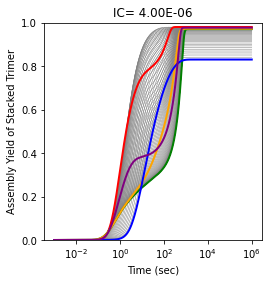

In [40]:
# ----------------------------------------------------------------
# --- Assembly Yield time courses + gray curves with synth/deg ---
# ----------------------------------------------------------------
 
# TURN THIS INTO FUNCTIONS 

print("Working on all AY tc WITH synth/deg...")
# --- PARAMETERS ---
# List of fixed parameters
numPlots = 100; #number of curves to plot
kOn = 10**6
IC_1 = 4*10**-6;
δ = 2.8*10**-4 # degradation rate parameter
Q = δ*IC_1 # synthesis rate parameter 
states_0 = [IC_1,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]
tEnd = 6 # 24hrs
tPts = 20000; t = 10**np.linspace(-3,tEnd,tPts)
minKdDeg = -12; maxKdDeg = -3

# define all the varibles that we will be sweeping through 
allKd1 = 10**np.linspace(minKdDeg,maxKdDeg,numPlots)
allKd2 = 10**np.linspace(minKdDeg,maxKdDeg,numPlots)
# store all tc's in a single matrix 
allAYs = np.zeros((numPlots,tPts))
# for each run we need to get the AY tc 
for runN in range(0,numPlots):
    if runN%100 == 0:
        print('Run: ', runN)
    kd1 = allKd1[runN] # binding affinity WITHIN rings (intra)
    kd2 = allKd2[runN] # binding affinity BETWEEN rings (inter)
    solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12)
    tVec=t;
    # now calc AY tc
    if δ == 0: # if no synthesis and degrdation 
        xStkTrm_tps_1 = solution_1[:,-1] # the fully stacked trimer
        Yn_1 = calcAY24hrs(IC_1,xStkTrm_tps_1)
    else:
        Yn_1 = calcAY_tc_synthDeg(tVec,solution_1);
    # and store the AY tc
    allAYs[runN,:]=Yn_1
        
# --- colored curves --- 
# lists of kd1 and kd2 
allKdPairs =[[10**-3, 10**-12], [10**-12, 10**-12], [10**-8, 10**-8], [10**-3, 10**-3], [10**-12, 10**-3]]
nPairs = len(allKdPairs)

allAYtc_SD = np.zeros((nPairs,tPts))
for kdI in range(0,nPairs): # for each IC 
    kdS = allKdPairs[kdI]; kd1 = kdS[0]; kd2 = kdS[1];
    # Now, integrate the ODEs and put the results in \"solution\"
    states_0 = [IC_1,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]
    solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-10, atol = 1e-10)
    tVec = t; xStkTrm_tps_1 = solution_1[:,-1]        
    # calculate AY
    #Yn_1 = calcAY24hrs(IC_1,xStkTrm_tps_1)
    Yn_1 = calcAY_tc_synthDeg(tVec,solution_1);
    # store AY time course
    allAYtc_SD[kdI,:]=Yn_1
     
# --- plot all curves --- 
fig = plt.figure()
ax = fig.add_subplot(111)

for runN in range(0,numPlots):
    plt.semilogx(tVec,allAYs[runN,:],'-', color = 'gray',linewidth=0.5)
# add the colored lines to plot

plt.semilogx(tVec,allAYtc_SD[0,:],'-', color = 'red',linewidth=2)
plt.semilogx(tVec,allAYtc_SD[1,:],'-', color = 'green',linewidth=2)
plt.semilogx(tVec,allAYtc_SD[2,:],'-',color = 'orange', linewidth=2)
plt.semilogx(tVec,allAYtc_SD[3,:],'-',color = 'blue', linewidth=2)
plt.semilogx(tVec,allAYtc_SD[4,:],'-',color = 'purple', linewidth=2)

x1,x2,y1,y2 = plt.axis(); plt.axis((x1,x2,0,1))

plt.title('IC= '+ ICFormat)
plt.xlabel('Time (sec)')
plt.ylabel('Assembly Yield of Stacked Trimer')

# --- save final plot --- 
ax.set_aspect(1./ax.get_data_ratio())
plt.savefig('SR_Aytc_wSynthDeg_'+today+'.eps')

print("Plot saved!")

Running for fixed IC...
Done will all pts!


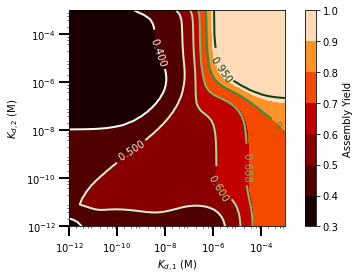

In [56]:
# ---------------------------------------------------
# --- Plot AY vs Kd1 vs Kd2 HEATMAP no synth/deg---
# ---------------------------------------------------
print("Working on heatmaps WITH NO synth/deg...")
# calculate the AY for Kd1 vs Kd2 values on a heatmap 

# --- PARAMETERS ---
# List of fixed parameters
kOn = 10**6
IC_val = 4*10**-6;
δ = 0 # degradation rate parameter
Q = δ*IC_val # synthesis rate parameter
# other parameters 
tEnd = 86400 # 24hrs
tPts = 2000; t = np.linspace(0,tEnd,tPts)

print("Running for fixed IC...")
# initializations 
nKdspts=50;
minDeg_kd1=-12;maxDeg_kd1=-3; # Kd1 pts
minDeg_kd2=-12;maxDeg_kd2=-3; # Kd2 pts

# start of function here!
mags_Kd1 = np.linspace(minDeg_kd1, maxDeg_kd1,nKdspts)
allKd1 = 10**mags_Kd1
# allKd1 = [10**-12, 10**-8, 10**-6,  10**-4, 10**-3]
mags_Kd2 = np.linspace(minDeg_kd2, maxDeg_kd2,nKdspts)
allKd2 = 10**mags_Kd2
#allKd2= [10**-12, 10**-8, 10**-6 , 10**-4, 10**-3]

kd1_kd2_AY_mat=np.zeros((nKdspts,nKdspts))
allTcs_mat = np.zeros((nKdspts,nKdspts,tPts))
# loop to solve AY for each IC 
for kd2ind in range(0,nKdspts): # for each IC 
    kd2_val=allKd2[kd2ind]; kd2 = kd2_val;
    for kd1ind in range(0,nKdspts): # for each value of kd2
        kd1_val=allKd1[kd1ind]; kd1 = kd1_val
        states_0 = [IC_val,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]
        # Now, integrate the ODEs and put the results in \"solution\"
        solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12)
        tVec = t; xStkTrm_tps_1 = solution_1[:,-1]        
        # calculate AY
        Yn_1 = calcAY24hrs(IC_val,xStkTrm_tps_1)
        # store the last AY value - since tc stops at 24hrs that's the AY at 24hrs
        AY_valStr = Yn_1[-1]; 
        #print("IC= " + str(icVal) + " , Kd2= " + str(kd2_val) + " , AY= " +  str(AY_valStr))
        # print("Kd1= ", kd1, " Kd2= ", kd2, "AY= ", AY_valStr)
        kd1_kd2_AY_mat[kd2ind][kd1ind] = AY_valStr # IC on x-axis, Kd on y-axis

#print("last pt: ",kd1_kd2_AY_mat[-1][-1])       
#print("with kd1= ", kd1, " and kd2= ", kd2)
print("Done will all pts!")

#AYmatPlt = np.flipud(kd1_kd2_AY_mat)
AYmatPlt = kd1_kd2_AY_mat
# AYmatPlt = np.fliplr(kd1_kd2_AY_mat)

fig, ax = plt.subplots()
# im = ax.imshow(AYmatPlt)
CS = ax.contourf(allKd2, allKd1, AYmatPlt,cmap=plt.cm.gist_heat)
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Assembly Yield')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')

# get ticks on log scale
ax.tick_params(axis="x", direction="out", length=10, width=2, color="black")
ax.tick_params(axis="y", direction="out", length=10, width=2, color="black")

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin); ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel('$K_{d,1}$ (M)', fontsize=10)
ax.set_ylabel('$K_{d,2}$ (M)', fontsize=10)

levels = [0.4, 0.5,0.6, 0.688, 0.8, 0.95]

CS = ax.contour(allKd2, allKd1, AYmatPlt, levels, 
                origin ='lower',
                cmap ='Greens',
                linewidths = 2,
                extent =(-1, 1, -1, 1))

ax.clabel(CS, levels,
          inline = 1, 
          fmt ='% 1.3f',
          fontsize = 10)

# --- save plot --- 
plt.tight_layout()
plt.savefig('LL_SR_heatmap_AYvsKd1vsKd2_n50_contours_'+today+'.eps')

Working on AY vs IC...
Done with AY vs IC pts


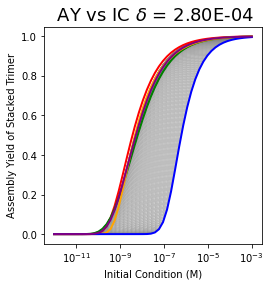

In [84]:
# ----------------------------------------------------
# --- Assembly Yield w Synth/Deg at 24hrs AY vs IC ---
# ----------------------------------------------------

print("Working on AY vs IC WITH synth/deg...")

# calculate AY vs IC 

# --- PARAMETERS ---
# List of fixed parameters
kOn = 10**6
δ_main = 2.8*10**-4 # degradation parameter term
δ = δ_main
# other parameters 
tEnd = 86400 # 24hrs
t = np.linspace(0,tEnd,2000)

# make vector of all IC to consider
nICpts=50;
minDeg_IC = -12; maxDeg_IC = -3;

# RED
# --- kd1 = 10^-3 & kd2 = 10^-12 ---
# Binding strengths
kd1 = 10**-3 ; kd2 = 10**-12 
kd1_1 = kd1; kd2_1= kd2; 
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_1 = allAY_ICs[0]; AYvsIC_1=allAY_ICs[1]
# GREEN
# --- kd1 = 10^-12 & kd2 = 10^-12 ---
kd1 = 10**-12 ; kd2 = 10**-12 
kd1_2 = kd1; kd2_2= kd2;
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_2 = allAY_ICs[0]; AYvsIC_2=allAY_ICs[1]
# ORANGE
# --- kd1 = 10^-8 & kd2 = 10^-8 ---
kd1 = 10**-8; kd2 = 10**-8
kd1_3 = kd1; kd2_3= kd2;
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_3 = allAY_ICs[0]; AYvsIC_3=allAY_ICs[1]
# BLUE
# --- kd1 = 10^-3 & kd2 = 10^-3 ---
kd1 = 10**-3; kd2 = 10**-3
kd1_4 = kd1; kd2_4= kd2;
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_4 = allAY_ICs[0]; AYvsIC_4=allAY_ICs[1]
# PURPLE
# --- kd1 = 10^-12 & kd2 = 10^-3 ---
kd1 = 10**-12; kd2 = 10**-3
kd1_5 = kd1; kd2_5= kd2;
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_5 = allAY_ICs[0]; AYvsIC_5=allAY_ICs[1]

# --- gray lines ---- 
minKdDeg = -12; maxKdDeg = -3
numPlots= 100
allAYsIC=np.zeros((numPlots,nICpts))
# define all the varibles that we will be sweeping through 
allKd1 = 10**np.linspace(minKdDeg,maxKdDeg,numPlots)
allKd2 = 10**np.linspace(minKdDeg,maxKdDeg,numPlots)
# store all tc's in a single matrix 
allAYsIC_sd = np.zeros((numPlots,nICpts))
# for each run we need to get the AY tc 
for runN in range(0,numPlots):
    kd1 = allKd1[runN] # binding affinity WITHIN rings (intra)
    kd2 = allKd2[runN] # binding affinity BETWEEN rings (inter)
    # now calc AY tc
    allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
    allICs_g = allAY_ICs[0]; AYvsIC_g=allAY_ICs[1]
    # and store the AY tc
    allAYsIC_sd[runN,:]=AYvsIC_g

print("Done with AY vs IC pts")

# --- Now plot curve ---
delta_val_format = format(δ_main,'.2E');
kd1_format_1 = format(kd1_1,'.2E');kd2_format_1 = format(kd2_1,'.2E')
kd1_format_2 = format(kd1_2,'.2E');kd2_format_2 = format(kd2_2,'.2E')
kd1_format_3 = format(kd1_3,'.2E');kd2_format_3 = format(kd2_3,'.2E')
kd1_format_4 = format(kd1_4,'.2E');kd2_format_4 = format(kd2_4,'.2E')
kd1_format_5 = format(kd1_5,'.2E');kd2_format_5 = format(kd2_5,'.2E')

fig = plt.figure()
ax = fig.add_subplot(111)

for runN in range(0,numPlots):
    plt.semilogx(allICs_1,allAYsIC_sd[runN,:],'-', color = 'gray',linewidth=0.5)

fig2 = plt.semilogx(allICs_1,AYvsIC_1,'r-',linewidth=2)
fig2 = plt.semilogx(allICs_2,AYvsIC_2,'g-',linewidth=2)
fig2 = plt.semilogx(allICs_3,AYvsIC_3,'-',linewidth=2, color='orange')
fig2 = plt.semilogx(allICs_4,AYvsIC_4,'b-',linewidth=2)
fig2 = plt.semilogx(allICs_5,AYvsIC_5,'-',linewidth=2, color='purple')

#plt.axis((x1,x2,0,1))
plt.title( " AY vs IC $\delta$ = " +delta_val_format, fontsize=18)
plt.xlabel('Initial Condition (M)')
plt.ylabel('Assembly Yield of Stacked Trimer')
#plt.legend(["Kd1="+kd1_format_1+", kd2=" +kd2_format_1, "Kd1="+kd1_format_2+", kd2=" +kd2_format_2, "Kd1="+kd1_format_3+", kd2=" +kd2_format_3,  "Kd1="+kd1_format_4+", kd2=" +kd2_format_4, "Kd1="+kd1_format_5+", kd2=" +kd2_format_5],loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()  
#plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())
plt.savefig('LL_SR_AYvsIC_sd_'+today+'.eps')
 



In [78]:
# ---------------------------------------------------
# --- Plot AY vs Kd1 vs Kd2 HEATMAP w synth/deg---
# ---------------------------------------------------
print("Working on heatmaps WITH synth/deg...")
# calculate the AY for Kd1 vs Kd2 values on a heatmap 

# --- PARAMETERS ---
# List of fixed parameters
kOn = 10**6
δ_main = 2.8*10**-4 # degradation parameter term
δ = δ_main # synthesis parameter
# IC_val = 4*10**-6
IC_val = 4*10**-8
Q = IC_val*δ
# other parameters 
tEnd = 86400 # 24hrs
t = np.linspace(0,tEnd,2000)

print("Running for fixed IC...")
# initializations 
nKdspts=50;
minDeg_kd1=-12;maxDeg_kd1=-3; # Kd1 pts
minDeg_kd2=-12;maxDeg_kd2=-3; # Kd2 pts

# start of function here!
mags_Kd1 = np.linspace(minDeg_kd1, maxDeg_kd1,nKdspts)
allKd1 = 10**mags_Kd1
mags_Kd2 = np.linspace(minDeg_kd2, maxDeg_kd2,nKdspts)
allKd2 = 10**mags_Kd2

kd1_kd2_AY_mat=np.zeros((nKdspts,nKdspts))
# loop to solve AY for each IC 
for kd2ind in range(0,nKdspts): # for each IC 
    kd2_val=allKd2[kd2ind]; kd2 = kd2_val;
    for kd1ind in range(0,nKdspts): # for each value of kd2
        kd1_val=allKd1[kd1ind]; kd1 = kd1_val
        states_0 = [IC_val,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0, 0.0,0.0]
        # Now, integrate the ODEs and put the results in \"solution\"
        solution_1 = odeint(stackedTrimer,states_0,t,rtol = 1e-12, atol = 1e-12)
        tVec = t; xStkTrm_tps_1 = solution_1[:,-1]
        # calculate AY
        Yn_1 = calcAY_synthDeg2hrs(tVec,solution_1);
        # store the last AY value - since tc stops at 24hrs that's the AY at 24hrs
        #AY_valStr = Yn_1[-1]; 
        AY_valStr = Yn_1;
        #print("IC= " + str(icVal) + " , Kd2= " + str(kd2_val) + " , AY= " +  str(AY_valStr))
        #kd1_kd2_AY_mat[kd1ind][kd2ind] = AY_valStr # IC on x-axis, Kd on y-axis
        kd1_kd2_AY_mat[kd2ind][kd1ind] = AY_valStr
        
print("Done will all pts!")
#print(kd1_kd2_AY_mat)

# ---------------------------------------------------
# --- Plot AY vs Kd1 vs Kd2 HEATMAP w contours ---
# ---------------------------------------------------

AYmatPlt=kd1_kd2_AY_mat

fig, ax = plt.subplots()
# im = ax.imshow(AYmatPlt)
CS = ax.contourf(allKd2, allKd1, AYmatPlt,cmap=plt.cm.gist_heat) 

cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Assembly Yield')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')

# get ticks on log scale
ax.tick_params(axis="x", direction="out", length=10, width=2, color="black")
ax.tick_params(axis="y", direction="out", length=10, width=2, color="black")

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin); ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_xlabel('$K_{d,1}$ (M)', fontsize=10)
ax.set_ylabel('$K_{d,2}$ (M)', fontsize=10)

levels = [0.1, 0.3, 0.5, 0.7, 0.75, 0.8]

CS = ax.contour(allKd2, allKd1, AYmatPlt, levels, 
                origin ='lower',
                cmap ='Greens',
                linewidths = 2,
                extent =(-1, 1, -1, 1))

ax.clabel(CS, levels,
          inline = 1, 
          fmt ='% 1.3f',
          fontsize = 10)

# --- save plot --- 
plt.tight_layout()
plt.savefig('LL_SR_heatmap_AYvsKd1vsKd2_synthDeg_contours_'+today+'.eps')

Running for fixed IC...
Done will all pts!


In [ ]:
# ---------------------------------------------------
# --- AY vs IC no synth/deg---
# ---------------------------------------------------

print("Working on AY vs IC WITH NO synth/deg...")

# --- PARAMETERS ---
# List of fixed parameters
kOn = 10**6
IC_val = 4*10**-6;
δ = 0 # degradation rate parameter
Q = δ*IC_val # synthesis rate parameter
# other parameters 
tEnd = 86400 # 24hrs
tPts = 2000; t = np.linspace(0,tEnd,tPts)

# make vector of all IC to consider
nICpts=50; minDeg_IC = -12; maxDeg_IC = -3;

# RED
# --- kd1 = 10^-3 & kd2 = 10^-12 ---
# Binding strengths
print("Red")
kd1 = 10**-3 ; kd2 = 10**-12 
kd1_1 = kd1; kd2_1= kd2; 
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_1 = allAY_ICs[0]; AYvsIC_1=allAY_ICs[1]
# GREEN
# --- kd1 = 10^-12 & kd2 = 10^-12 ---
print("Green")
kd1 = 10**-12 ; kd2 = 10**-12 
kd1_2 = kd1; kd2_2= kd2;
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_2 = allAY_ICs[0]; AYvsIC_2=allAY_ICs[1]
# ORANGE
# --- kd1 = 10^-8 & kd2 = 10^-8 ---
print("Orange")
kd1 = 10**-8; kd2 = 10**-8
kd1_3 = kd1; kd2_3= kd2;
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_3 = allAY_ICs[0]; AYvsIC_3=allAY_ICs[1]
# BLUE
# --- kd1 = 10^-3 & kd2 = 10^-3 ---
print("Blue")
kd1 = 10**-3; kd2 = 10**-3
kd1_4 = kd1; kd2_4= kd2;
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_4 = allAY_ICs[0]; AYvsIC_4=allAY_ICs[1]
# PURPLE
# --- kd1 = 10^-12 & kd2 = 10^-3 ---
print("Purple")
kd1 = 10**-12; kd2 = 10**-3
kd1_5 = kd1; kd2_5= kd2;
allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
allICs_5 = allAY_ICs[0]; AYvsIC_5=allAY_ICs[1]

# --- gray lines ---- 
minKdDeg = -12; maxKdDeg = -3
numPlots= 100
allAYsIC=np.zeros((numPlots,nICpts))
# define all the varibles that we will be sweeping through 
allKd1 = 10**np.linspace(minKdDeg,maxKdDeg,numPlots)
allKd2 = 10**np.linspace(minKdDeg,maxKdDeg,numPlots)
# store all tc's in a single matrix 
allAYsIC_sd = np.zeros((numPlots,nICpts))
# for each run we need to get the AY tc 
for runN in range(0,numPlots):
    if runN%10 == 0:
        print("Run: ", runN)
    kd1 = allKd1[runN] # binding affinity WITHIN rings (intra)
    kd2 = allKd2[runN] # binding affinity BETWEEN rings (inter)
    # now calc AY tc
    allAY_ICs = calc_AYvsIC_synthDeg(minDeg_IC, maxDeg_IC, nICpts)
    allICs_g = allAY_ICs[0]; AYvsIC_g=allAY_ICs[1]
    # and store the AY tc
    allAYsIC_sd[runN,:]=AYvsIC_g

print("Done with AY vs IC pts")

not these!
not these!
not these!
not these!


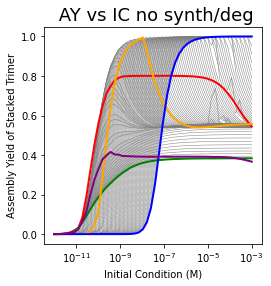

In [61]:
# --- Now plot curve ---
#delta_val_format = format(δ_main,'.2E');
kd1_format_1 = format(kd1_1,'.2E');kd2_format_1 = format(kd2_1,'.2E')
kd1_format_2 = format(kd1_2,'.2E');kd2_format_2 = format(kd2_2,'.2E')
kd1_format_3 = format(kd1_3,'.2E');kd2_format_3 = format(kd2_3,'.2E')
kd1_format_4 = format(kd1_4,'.2E');kd2_format_4 = format(kd2_4,'.2E')
kd1_format_5 = format(kd1_5,'.2E');kd2_format_5 = format(kd2_5,'.2E')

fig = plt.figure()
ax = fig.add_subplot(111)

for runN in range(0,numPlots):    
    # take off that weird one
    if runN == 14 or runN == 17 or runN == 21 or runN == 28: #or runN == 16:
        print("not these!")
    else:
        plt.semilogx(allICs_1,allAYsIC_sd[runN,:],'-', color = 'gray',linewidth=0.5)
        

fig2 = plt.semilogx(allICs_1,AYvsIC_1,'r-',linewidth=2)
fig2 = plt.semilogx(allICs_2,AYvsIC_2,'g-',linewidth=2)
fig2 = plt.semilogx(allICs_3,AYvsIC_3,'-',linewidth=2, color='orange')
fig2 = plt.semilogx(allICs_4,AYvsIC_4,'b-',linewidth=2)
fig2 = plt.semilogx(allICs_5,AYvsIC_5,'-',linewidth=2, color='purple')

#plt.axis((x1,x2,0,1))
plt.title( " AY vs IC no synth/deg", fontsize=18)
plt.xlabel('Initial Condition (M)')
plt.ylabel('Assembly Yield of Stacked Trimer')
#plt.legend(["Kd1="+kd1_format_1+", kd2=" +kd2_format_1, "Kd1="+kd1_format_2+", kd2=" +kd2_format_2, "Kd1="+kd1_format_3+", kd2=" +kd2_format_3,  "Kd1="+kd1_format_4+", kd2=" +kd2_format_4, "Kd1="+kd1_format_5+", kd2=" +kd2_format_5],loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()  
#plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())
plt.savefig('LL_SR_AYvsIC_sd_'+today+'.eps')
 